# *Análisis Exploratorio de Datos - Broom Broom Cars S.L.* 
**by** *Carlos Cabruja*

![](https://challenges-asset-files.s3.us-east-2.amazonaws.com/JOBarcelona+2022/business.png)

Acabas de entrar en el departamento de Analytics y Business Intelligence de una cadena de concesionarios de coches de segunda mano que se llama Broom Broom Cars S.L. La empresa está situada en Gran Bretaña y tú eres responsable de maximizar la venta de coches a las afueras del sur de Londres.

Los cargos directivos de la empresa están muy emocionados con tu incorporación ya que, por fin, van a poder apoyar sus decisiones en datos. Por este motivo, se te ha concedido un una lista con todos los coches vendidos de los concesionarios de la zona durante el año 2020 y 2021. [Lista](https://challenges-asset-files.s3.us-east-2.amazonaws.com/JOBarcelona+2022/cars_bought_UK_2021.csv).

El objetivo del reto es generar un dashboard o presentación que permita al equipo directivo ver cuáles son los coches que han tenido más éxito durante 2020 y 2021, ver cuál es la tendencia y dar tu recomendación sobre los coches que Broom Broom Cars S.L. tiene que intentar obtener para sus concesionarios durante el año 2022.

Las variables del dataset son las siguientes:

*   *Model*: Modelo del coche
*   *Price*: Precio de venta
*   *Transmission*: Tipo de transmisión
*   *Mileage*: Millas que había recorrido el coche antes de la venta
*   *Fuel Type*: Tipo de combustible
*   *Tax*: Impuestos de venta
*   *Miles Per Gallon (mpg)*: Millas consumidas por cada galón de combustible
*   *Engine Size*: Tamaño del motor
*   *Maker*: Fabricante

Preguntas:

**¿Qué coches o tipo de coches tenemos que comprar en nuestro concesionario para así generar más ingresos durante el año 2022.?**

*   ¿Cuáles son las marcas de coches que generan más ingresos?
*   ¿Cuáles son los coches que generan más ingresos (tanto por coche como en conjunto)?
*   ¿Hay dependencias entre el tamaño del motor y el precio de venta?
*   ¿Es importante fijarse en los impuestos a pagar por el coche?
*   ¿Qué modelo es el que le gusta más a la gente? ¿Y el que ha generado más ingresos de manera global?
*   ¿Vale la pena targetear coches de transmisión híbrida? ¿Qué transmisión es la mejor? ¿Y los consumidores se fijan en el mpg?
*   ¿El milage hace bajar el precio de los coches exponencialmente, linialmente o logarítmicamente?

### 1. Cargado de datos

In [1]:
# Librerias necesarias para el procesamiento de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import squarify

sns.set_theme(style='darkgrid', palette='deep')

In [2]:
# carga de datos
ruta = 'data/cars_bought_UK_2021.csv'
df_vehiculos = pd.read_csv(ruta, sep=';')
df_vehiculos # imprime el dataframe

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make
0,5 Series,42995,Automatic,7500,Hybrid,135,"156,9",2,BMW
1,Q5,48990,Semi-Auto,5000,Hybrid,135,"117,7",2,audi
2,2 Series,34975,Semi-Auto,5,Diesel,145,"48,7",2,BMW
3,Q5,35500,Semi-Auto,3500,Diesel,145,"38,2",2,audi
4,TT,28800,Semi-Auto,241,Petrol,145,"40,9",2,audi
...,...,...,...,...,...,...,...,...,...
3311,Kamiq,18991,Manual,986,Petrol,145,"47,1","1,5",skoda
3312,X5,52990,Semi-Auto,5899,Diesel,145,"37,7",3,BMW
3313,Up,10980,Manual,100,Petrol,145,"54,3",1,vw
3314,X2,23450,Manual,15,Diesel,145,"55,4",2,BMW


In [3]:
df_vehiculos.info() # informacion del dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   model         3316 non-null   object
 1   price         3316 non-null   int64 
 2   transmission  3316 non-null   object
 3   mileage       3316 non-null   int64 
 4   fuelType      3316 non-null   object
 5   tax           3316 non-null   int64 
 6   mpg           3316 non-null   object
 7   engineSize    3316 non-null   object
 8   Make          3316 non-null   object
dtypes: int64(3), object(6)
memory usage: 233.3+ KB


El tamaño de nuestro dataset es de 3316 filas por 8 columnas, y parece que no hay valores nulos, pero las millas recorridas por galón y el tamaño del motos son variables procesadas como object debido al caracter "," y habrá que transformarlas a float, y la variable *tax* es una variable categórica porque son cantidades fijas de impuestos.

### 2. Limpieza de datos

Para la limpieza de datos, nos haremos una copia del dataset original, y buscaremos eliminar las filas que no aportan información para el análisis.

In [4]:
df = df_vehiculos.copy()

In [5]:
# ¿Hay valores duplicados?
print("Hay", df.duplicated().sum(), "valores duplicados")

Hay 118 valores duplicados


Vamos a tratar estos duplicados como que se ha vendido el mismo coche, con exactamente las mismas características, por que crearemos una columna cantidad que sea la cantidad de veces que se ha vendido el coche.

In [6]:
# Cantidad de valores por columna
df = df.groupby(df.columns.to_list(), as_index=False).size() 
df.rename(columns={'size': 'cantidad'}, inplace=True) # renombra la columna
print("Se han eliminado", len(df_vehiculos) - len(df), "valores duplicados")

Se han eliminado 118 valores duplicados


Y ahora vamos a crear la columna *ventas* que será la cantidad de veces que se ha vendido el coche por el precio de venta.

In [7]:
df['ventas'] = df['cantidad'] * df['price']

In [8]:
# Transforma tax en object
df['tax'] = df['tax'].astype(str)

In [9]:
 # Reemplazar en mpg los "," por "."
df.mpg = df.mpg.str.replace(',', '.')

# Transformar mpg a float  
df.mpg = df.mpg.astype(float)

In [10]:
# Reemplazar en engineSize los "," por "."
df.engineSize = df.engineSize.str.replace(',', '.')

# Transformar engineSize a float
df.engineSize = df.engineSize.astype(float)

In [11]:
df.engineSize.unique()

array([2. , 1.5, 3. , 1. , 1.6, 1.4, 1.8, 1.2, 2.5, 1.1, 2.3, 2.4, 0. ,
       2.8, 5. , 4. , 5.2, 2.9, 2.2, 4.4])

¿Tamaño de motor 0? Veamos que filas tienen ese valor.

In [12]:
# Filas con engineSize = 0
df[df.engineSize == 0]

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make,cantidad,ventas
1477,Ka+,11999,Manual,2000,Petrol,145,43.5,0.0,Ford,1,11999
1975,Q2,24888,Automatic,1500,Petrol,145,42.2,0.0,audi,1,24888
1979,Q2,24988,Automatic,1500,Petrol,145,42.2,0.0,audi,1,24988
1980,Q2,24990,Manual,1500,Petrol,145,43.5,0.0,audi,2,49980
2046,Q3,29488,Manual,1500,Petrol,145,40.9,0.0,audi,1,29488
2050,Q3,29944,Automatic,1500,Petrol,145,32.5,0.0,audi,1,29944
2051,Q3,29944,Manual,1500,Petrol,145,40.9,0.0,audi,1,29944
2055,Q3,29990,Automatic,1500,Diesel,145,47.1,0.0,audi,1,29990
2058,Q3,30000,Automatic,1500,Petrol,145,40.9,0.0,audi,1,30000
2065,Q3,30990,Manual,1500,Petrol,145,40.9,0.0,audi,2,61980


Parece que son los modelos de audi, los que tienen un tamaño de motor 0, pero podemos observar que las milllas recorridas por galón son muy parecidas excepto en el modelo Q5 donde el impuesto es 135, más adelante intentaremos estimar el tamaño del motor de los modelos de audi que tienen un tamaño de motor 0 para el resto del análisis, lo mejor será trabajar realmente a una variable cátegorica de tipo object, que estará distribuida de la siguente manera:

- Motor pequeño = 1 
- Motor mediano = 1 - 2
- Motor grande = 2 - 3
- Motor muy grande = > 3

In [13]:
# Crear columna de tamaño del motor
# Motor pequeño = 1
df['tamanoMotor'] = np.where(df.engineSize == 1, 'motor pequeño',df.engineSize)
# Motor mediano = 1 - 2
df['tamanoMotor'] = np.where(((df.engineSize > 1) & (df.engineSize <= 2)), 'motor mediano', df.tamanoMotor)
# Motor grande = 2 - 3
df['tamanoMotor'] = np.where(((df.engineSize > 2) & (df.engineSize <= 3)), 'motor grande',  df.tamanoMotor)
# Motor muy grande = > 3   
df['tamanoMotor'] = np.where(df.engineSize > 3, 'motor muy grande',  df.tamanoMotor)

Teniendo nuestras variables en el formato correcto, vamos a estudiar los outliers...

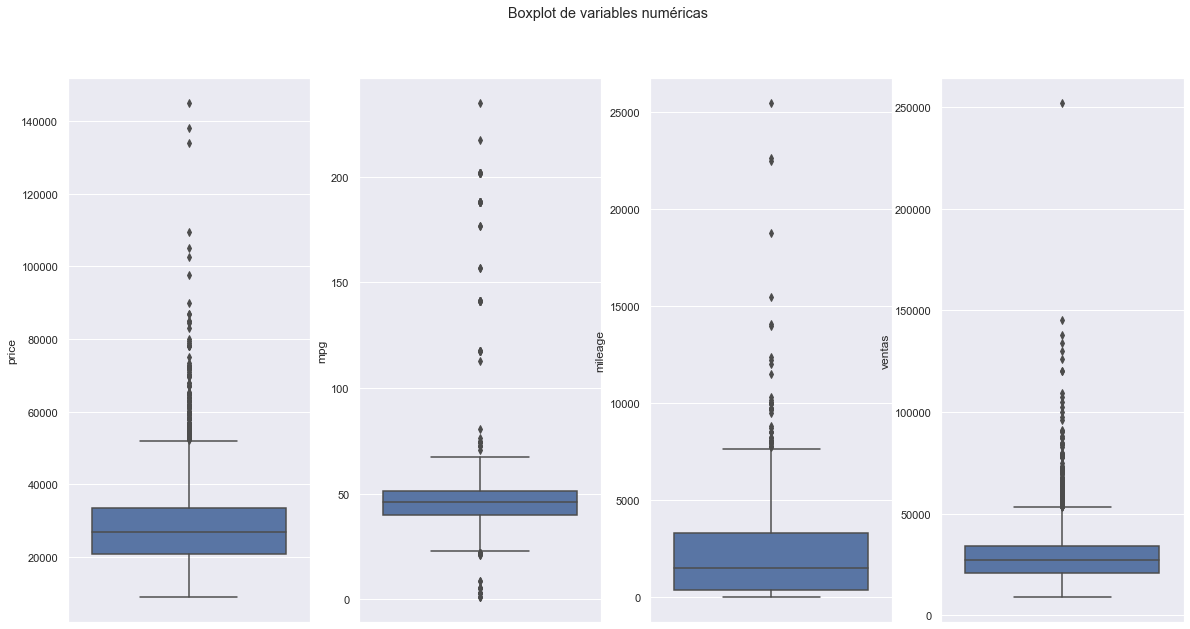

In [14]:
# boxplot de nuestras variables númericas
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10), sharey='none')
fig.suptitle('Boxplot de variables numéricas')

# boxplot de precio
sns.boxplot(y='price', data=df, ax=axs[0], )
# boxplot de mpg
sns.boxplot(y='mpg', data=df, ax=axs[1])
# boxplot de mileage
sns.boxplot(y='mileage', data=df, ax=axs[2])
# boxplot de ventas
sns.boxplot(y='ventas', data=df, ax=axs[3])

plt.show()

Aquí podemos ver que el concesionario, tiene coches con un **precio** muy alejado de su rango de precio de venta, los **mpg** se podría estudiar a través del tamaño del motor, ya que sería posible que motores muy grandes consuman más combustible por milla. También vemos que tienen coches que han hecho mucho **recorrido** antes de su venta y que se produjo una **venta** extraordinaria de un modelo de coche que generó 250.000

Veamos igual así de forma general cuantos outliers hay en el dataset.

In [15]:
# Curiosidad: ¿Qué modelo generó ese outliers en ventas?
df[df.ventas >= 250000]

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make,cantidad,ventas,tamanoMotor
1709,Passat,20998,Semi-Auto,15,Diesel,145,49.6,1.6,vw,12,251976,motor mediano


In [16]:
# Encontrar el valor z de las variables
var_nums = df[['price', 'mpg', 'mileage', 'ventas']].copy()
z = np.abs(stats.zscore(var_nums))
clean_df = df[(z < 3).all(axis=1)]

print("Se han eliminado", len(df) - len(clean_df), "outliers")
print("Que representa un", round(((len(df) - len(clean_df)) / len(df)) * 100, 2), "%")

Se han eliminado 133 outliers
Que representa un 4.16 %


Pues parece que no hay muchos outliers, sin embargo nos guardamos nuestra variable con los outliers por si nos hiciese falta para confimar algunas conclusiones.

In [17]:
# guardar dataframe con outliers
ruta = 'data/df_outliers.pkl'
df.to_pickle(ruta)

# guardar dataframe limpio
ruta = 'data/df_clean.pkl'
clean_df.to_pickle(ruta)

df = clean_df.copy()

### 3. Análisis univariante

Ya hemos visto un poco como están distribuidas nuestras variables numéricas, ahora vamos a ver con más detalle nuestras variables categóricas.

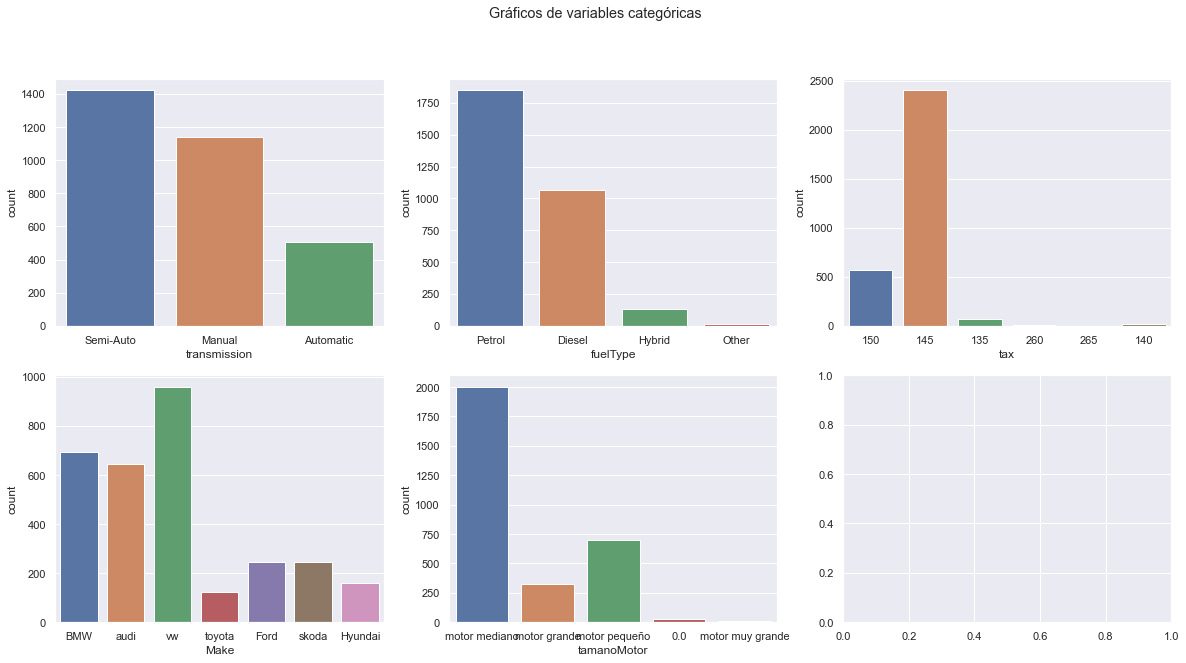

In [18]:
# gráfico de barras de transmission, fuelType, tax, Make y tamanoMotor
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharey='none')
fig.suptitle('Gráficos de variables categóricas')

    # gráfico de transmission
sns.countplot(x='transmission', data=df, ax=axs[0,0])
    # gráfico de fuelType
sns.countplot(x='fuelType', data=df, ax=axs[0,1])
    # gráfico de tax
sns.countplot(x='tax', data=df, ax=axs[0,2])
    # gráfico de Make
sns.countplot(x='Make', data=df, ax=axs[1,0])
    # gráfico de tamanoMotor
sns.countplot(x='tamanoMotor', data=df, ax=axs[1,1])

plt.show()

Aquí podemos ver, que la mayoría de los coches que se venden son:

* Transmisión semi-automática
* Tipo de combustible gasolina
* Se les aplica un impuesto de 145
* De la marca Volkswagen
* De motores medianos (1 - 2 litros)

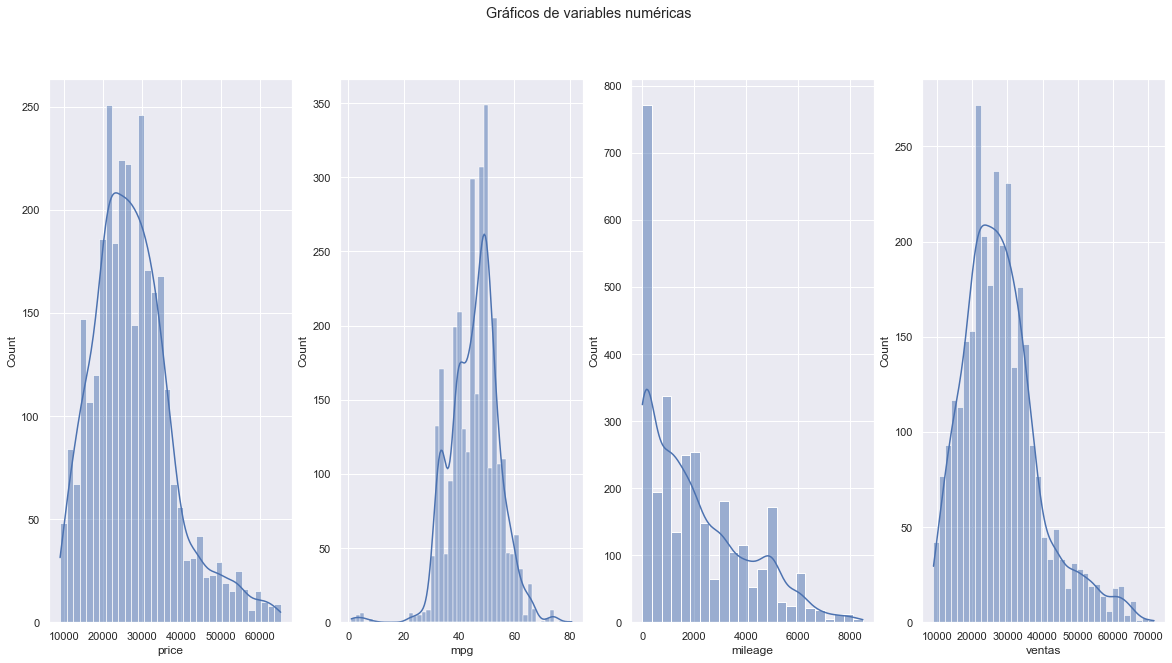

In [19]:
# graficos de distribución de precio, mpg, mileage
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10), sharey='none')
fig.suptitle('Gráficos de variables numéricas')

    # gráfico de precio
sns.histplot(df.price, kde=True, ax=axs[0])
    # gráfico de mpg
sns.histplot(df.mpg, kde=True, ax=axs[1]) 
    # gráfico de mileage    
sns.histplot(df.mileage, kde=True, ax=axs[2])
    # gráfico de ventas
sns.histplot(df.ventas, kde=True, ax=axs[3])
plt.show()

Ninguna de nuestras variables númericas parece que siga una distribución normal estudidada por si sola, pero podriamos decir que la mayoría de los coches que se venden tienen:

* Un precio entre 10.000 y 40.000 
* Que la mayoría de los coches tienen una mpg entre 30 y 60
* Que la mayoría recorrió menos de 2000 millas
* Que la mayoría de los modelos generan menos de 50.000 en ventas

### 4. Análisis bivariante

Antes vimos que la mayoría de los coches que se venden tienen un precio entre 10.000 y 40.000, ¿cuales marcas venden coches con ese precio? (Vamos a rescatar los outliers para seguir con el análisis de outliers)

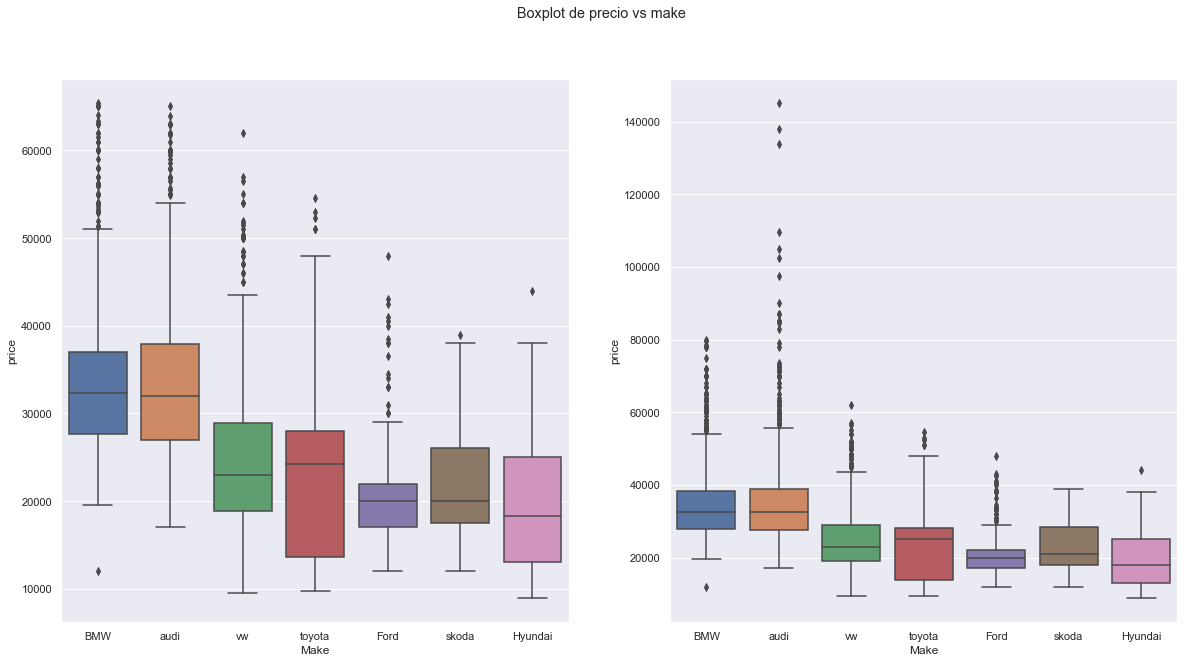

In [20]:
df_outliers = pd.read_pickle('data/df_outliers.pkl')

# boxplot precio vs make
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey='none')
fig.suptitle('Boxplot de precio vs make')
sns.boxplot(x='Make', y='price', data=df, ax=axs[0])
sns.boxplot(x='Make', y='price', data=df_outliers, ax=axs[1])
plt.show()

Aquí podemos ver que la marca que representaba los outliers en precio era los coches audi, y vemos que las marcas que están un poco fuera del rango del precio es BMW y audi, pero es curioso notar que la marca Volkswagen (que es la más vendida) tiene un rango de precios que cubre desde los 10.000 a los 40.000. Por lo que tenemos un primer indicio de que Volkswagen es una marca que se vende muy bien.

¿Cuales son las marcas que generan más ingresos?

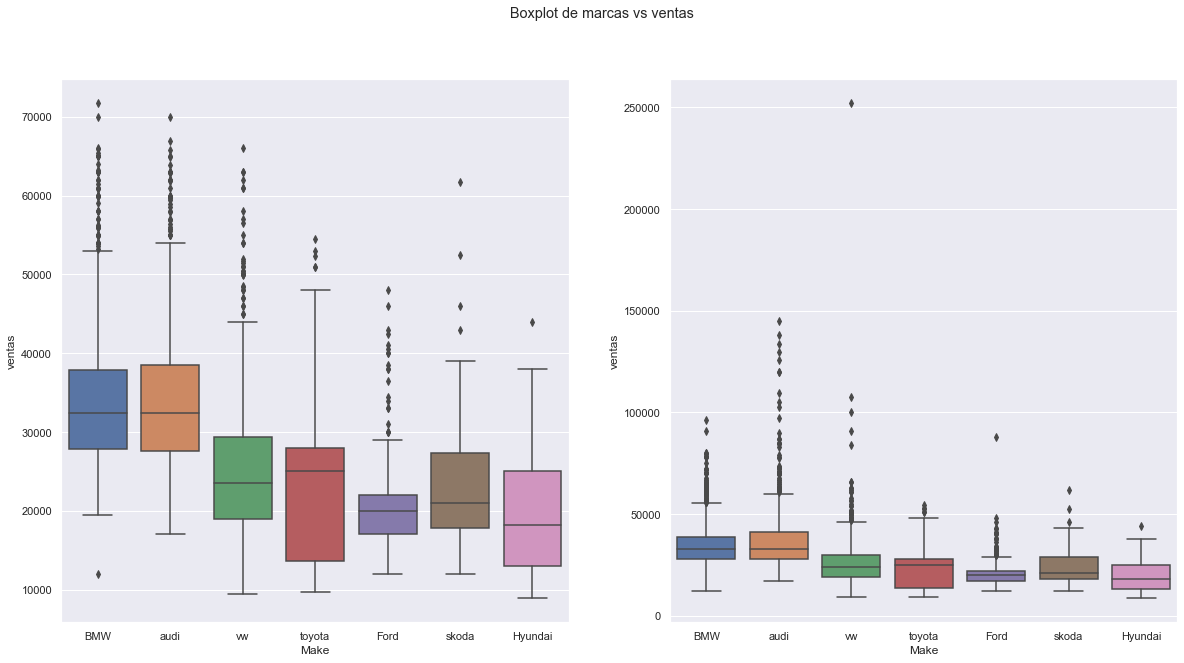

In [21]:
# boxplot marcas vs ventas
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey='none')
fig.suptitle('Boxplot de marcas vs ventas')
sns.boxplot(x='Make', y='ventas', data=df, ax=axs[0])
sns.boxplot(x='Make', y='ventas', data=df_outliers, ax=axs[1])
plt.show()

Aquí vemos que limpiando los outliers de la columna ventas, se comporta muy parecido a la columna de precios, por lo que podemos pensar que aunque BMW y audi son coches que se alejan un poco del rango de precios de los más vendidos son los que generan más ingresos, sin embargo, ahora podemos preguntarnos es *¿la media de ventas de volkswagen, distinta a la media de ventas de audi y BMW?*

In [22]:
# ¿Nuestra columna ventas es normal?
exp, p = stats.normaltest(df.ventas)
if p < 0.05:
    print("La columna ventas no se comporta como una distribución normal")
else:   
    print("La columna ventas se comporta como una distribución normal")

La columna ventas no se comporta como una distribución normal


Como nuestra columna de ventas del año 2021 no se comporta como una distribución normal y no tenemos certeza que las ventas de este concesionario se comporte con esa distribución nos valdremos de una prueba no paramétrica que asume que los datos provienen de una misma distribución, la prueba de Kruskal-Wallis.

In [23]:
# ¿Es la media de volkswagen distinta a la media de ventas de audi y BWM?
vw = df[df.Make == 'vw']['ventas'].values
audi = df[df.Make == 'audi']['ventas'].values
bwm = df[df.Make == 'BMW']['ventas'].values

# test de hipótesis
exp, p = stats.kruskal(vw, audi, bwm)
if p < 0.05:
    print("Por lo menos una de las medias es distinta a la otra")
    
    # compramos marca por marca
    lista_make = [vw, audi, bwm]
    lista_name = ['vw', 'audi', 'bwm']

    for i in range(len(lista_make)):
        for j in range(i+1, len(lista_make)):
            exp, p = stats.kruskal(lista_make[i], lista_make[j])
            if p < 0.05:
                print("Las medias de", lista_name[i], "y", lista_name[j], "son distintas")

Por lo menos una de las medias es distinta a la otra
Las medias de vw y audi son distintas
Las medias de vw y bwm son distintas


Vemos que a pesar de que el coche volkswagen tiene una venta muy alta, los BMW y audi son los que generan más ingresos, que tiene sentido ya que son las 2da y 3era marca más vendidas en el concesionario. Aquí vemos la importancia de el análisis de datos, ya que descubrimos que a pesar de que volkswagen tiene una venta muy alta, y está dentro del rango de precios más vendidos, no genera más ingresos que los BMW y audi.

Por curiosidad vimos en el anterior gráfico de cantidad de marcas que se vendieron que los toyota eran el coche menos vendidos, pero *¿será la media de ventas de los toyota distinta a la media de los volkswagen?*

In [24]:
# ¿Es la media de volkswagen distinta a la media de los toyota?
vw = df[df.Make == 'vw']['ventas'].values
toyota = df[df.Make == 'toyota']['ventas'].values

    # test de hipótesis
exp, p = stats.kruskal(vw, toyota)
if p < 0.05:
    print("Las medias son distintas")
else:
    print("Las medias no son distintas")

Las medias no son distintas


Pues confirmamos que la marca volkswagen tiene truco, que a pesar de que fue la marca que produjo una venta de más de 250.000, no genera más ingresos (estadísticamente) que los toyota que son la marca que menos se vendió en el concesionario! 

In [25]:
# Tabla de medias de ventas de todas las marcas
tabla = pd.DataFrame(columns=['Make', 'Media'])

for make in df.Make.unique():
    media = df[df.Make == make]['ventas'].mean()
    tabla = pd.concat([tabla, pd.DataFrame({'Make': make, 'Media': media}, index=[0])])

tabla.sort_values(by='Media', ascending=False)

,Make,Media
0,BMW,34598.776012
0,audi,34485.576087
0,vw,24711.264859
0,toyota,23098.745902
0,skoda,22817.089796
0,Ford,20838.946939
0,Hyundai,19788.474684


Pues con esta tabla confirmamos que los coches más ingresos generan son los BMW y audi, ya que poseen estadísticamente la misma cantidad de ventas.

Ahora vamos a ver los modelos que se vendieron más, como se comportan...

### 5. Análisis multivariante

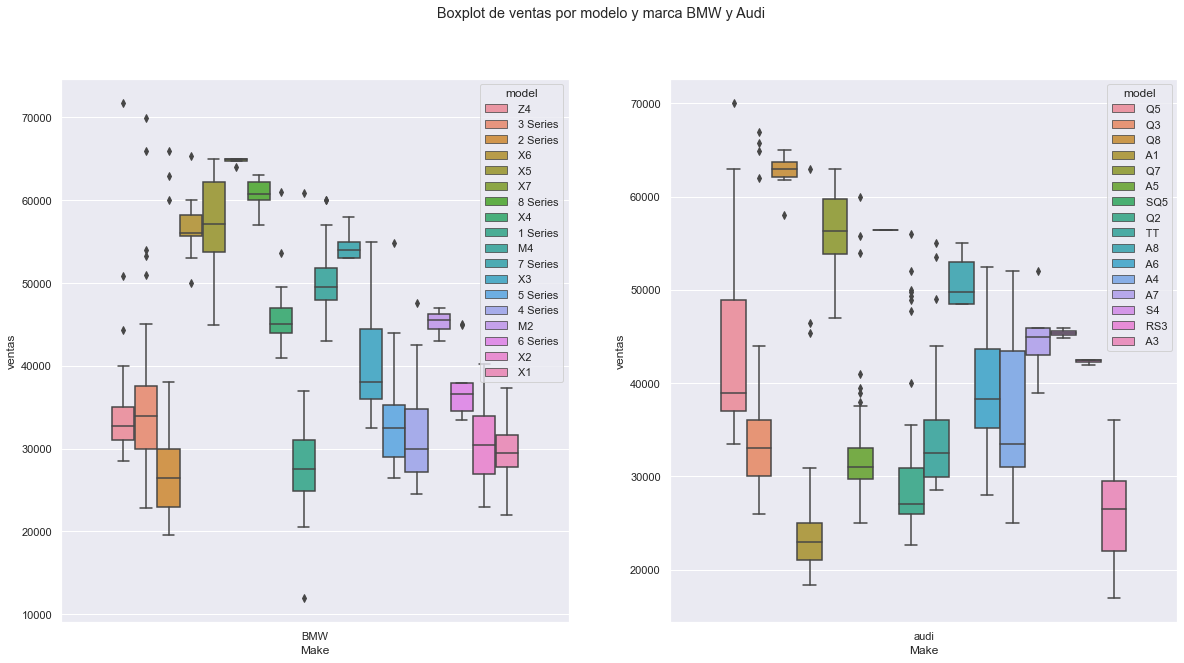

In [26]:
# Gráfico boxplot de ventas por modelo y marca BMW y Audi
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey='none')
fig.suptitle('Boxplot de ventas por modelo y marca BMW y Audi')
sns.boxplot(x='Make', y='ventas', hue="model", data=df[df.Make == 'BMW'].sort_values(by='ventas', ascending=False), ax=axs[0])
sns.boxplot(x='Make', y='ventas', hue="model", data=df[df.Make == 'audi'].sort_values(by='ventas', ascending=False), ax=axs[1])
plt.show()

Vemos en el caso de los **BMW**, nos dice que los modelos **Z4** fueron los que más dinero en ventas generó, pero vemos que fue por una venta que se produjo en más de 70.000, pero que en promedio los modelos **Z4** generan entre 30.000 y 40.000 en ventas, que entra dentro del rango de precios más vendidos. Pero el claro ganador de los modelos **BMW** fue el X5 que produjo en ventas entre los 45.000 y 65.000 y en el caso de los **Audi**, si el claro ganador es el modelo **Q5**, generando ventas entre los 35.000 y 60.000, después pudiesemos decir que el modelo **A5** es el segundo mejor vendido generando ventas entre los 45.000 y 65.000. De igual forma vamos a completar la idea que nos podamos hacer, viendo un cuales fueron los modelos que se vendieron más, que no quiere decir que sean los que generan más ingresos.

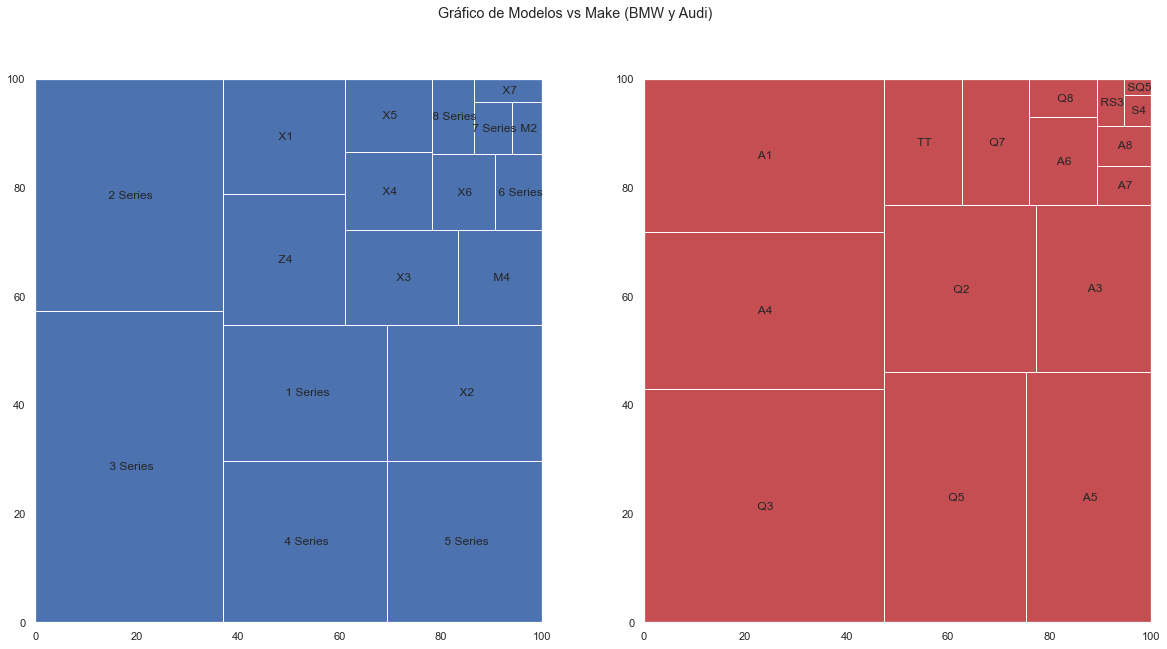

In [56]:
# Gráfico de Modelos vs Make (BMW y Audi)
bmw = df[df.Make == 'BMW']['model'].value_counts()
audi = df[df.Make == 'audi']['model'].value_counts()

# gráfico de modelos    
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey='none')
fig.suptitle('Gráfico de Modelos vs Make (BMW y Audi)')
squarify.plot(sizes=bmw.values, label=bmw.index, color='b', ax=axs[0])
squarify.plot(sizes=audi.values, label=audi.index, color='r', ax=axs[1])
plt.show()

En este gráfico vemos que el **Z4** y el **X5** a pesar de ser los modelos que más ingresos generaron, no son los modelos **BMW** que más se venden, sino que son los modelos serie, siendo **3 Series** el más vendido, así que nos pudiesemos preguntar si es la media de los ingresos producidos por **3 Series** distinta a la media de ingresos producidos por el modelo **X5** que es el coche donde los datos están en el rango de ingresos más altos. 

Y en el caso de los **Audi** el **Q3** es el más vendido pero no muy distinto del grupo **Q5**, **A5**, **A1**, **A4**, por lo que el **Q5** sigue siendo nuestro candidato a ganador con un rango de ingresos bastante amplio, pero si vemos el gráfico anterior de los ingresos el **A1** parece prometedor ya que es modelo que generó más ingreso de los modelos de **Audi**.

In [28]:
# Curiosidad: Modelo BMW que se vendió en más de 70.000
df.loc[(df.Make == 'BMW') & (df.ventas > 70000)]

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make,cantidad,ventas,tamanoMotor
3190,Z4,35850,Semi-Auto,5,Petrol,145,37.2,2.0,BMW,2,71700,motor mediano


*¿Es la media de ingresos de el modelo 3 Series de BMW distinta a la media de ingresos de el modelo X5?*